### Homework 2

Given input video from camera with rolling shutter, implement and apply the following algorithms:

    - radial distortion correction (use cv2.fisheye module)
    - rolling shutter correction
    - video stabilization

Expected output of the homework:

    - Jupyter notebook with working code that we can run in real-time
    - plots of camera orientations in time for unstabilized and stabilized motion [plot individual x/y/z components in axis-angle representation]
    - plots of input/output meshgrids for the video frame, where angular velocity has the biggest norm
    - 4 videos stacked together with their frames side-by-side:
        - original
        - undistorted 
        - undistorted + rolling shutter corrected
        - undistorted + rolling shutter corrected + stabilized

Note:
Dataset used in homework provides two sources of camera orientations: IMU (Gyro) measurements of angular velocity and Motion Capture direct measurements of orientation. You should use IMU (Gyro) measurements and implement angular velocity integration. You can use Motion Capture direct measurements of orientation to verify that your integration is implemented correctly.

Rolling shutter correction algorithm is based on this paper: [Digital Video Stabilization and Rolling Shutter Correction using Gyroscopes](https://graphics.stanford.edu/papers/stabilization/).

Dataset: [Rolling-Shutter Visual-Inertial Odometry Dataset](https://cvg.cit.tum.de/data/datasets/rolling-shutter-dataset)

Calibrated camera params can be found [here](https://cdn3.vision.in.tum.de/rolling/calibration/camchain-calibration-equidistant4_camimu_dataset-calib-imu1.yaml)

![Camera Set-up](https://cvg.cit.tum.de/_media/data/datasets/rolling-shutter-dataset/sensor_axes_rgb.jpg?w=800&tok=fa3d4a)

Install packages

In [1]:
! pip install numpy >> /dev/null
! pip install pandas >> /dev/null
! pip install opencv-python >> /dev/null
! pip install scipy >> /dev/null
! pip install torch >> /dev/null
! pip install matplotlib >> /dev/null
! pip install git+https://github.com/NVlabs/nvdiffrast >> /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast /tmp/pip-req-build-f55ks6xv


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

## Preprocessing camera data

In [3]:
INPUT_DIR = "data" # replace with your sequence
ORIGINAL_VIDEONAME = "output/orig.mp4"
UNDISTORTED_VIDEONAME = "output/undist.mp4"
RS_REMOVED_VIDEONAME = "output/nors.mp4"
STABILIZED_VIDEONAME = "output/stable_nors.mp4"
COMPARISON_VIDEONAME = "output/compared.mp4"

# camera params
FPS = 20

# camera intrinsics
K = np.array([[739.1654756101043, 0.0, 625.826167006398],
              [0.0, 739.1438452683457, 517.3370973594253],
              [0.0, 0.0, 1.0]])

# output camera intrinsics
K_new = K 

# distortion params
D = np.array([0.019327620961435945, 0.006784242994724914, -0.008658628531456217, 0.0051893686731546585])


T_cam_imu = np.array([[-0.0027687291789002095, -0.9999872674970001, 0.004218884048773266, -0.05688384754602901],
                       [-0.9999356528558058, 0.002814949729190873, 0.010989367855138411, 0.007618902284014501],
                       [-0.011001103879489809, -0.004188185992194848, -0.9999307150055582, -0.042436390295094266],
                       [0.0, 0.0, 0.0, 1.0]])

R_cam_imu = T_cam_imu[:3, :3]

# time difference between row's light capture
dt_rs = 29.47 * 10 ** -6  # in seconds

# frame dimensions
W, H = 1280, 1024

In [4]:
def frames_to_video(frames, output_video, fps=20, isColor=False):
    """
    Create a video from a list of frames.

    :param frames: list of frames
    :param output_video: output video file name (e.g., 'output.mp4')
    :param fps: frames per second (default=20)
    """
    if len(frames) == 0:
        raise ValueError("No frames provided")

    # Use the first frame to get dimensions
    height, width, *channels = frames[0].shape

    # Define video writer (using mp4v codec)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=isColor)

    for frame in tqdm(frames, desc="Writing frames to video: "):
        video.write(frame)
        

frames_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "cam1/data/*.png")))
print(f"Number of frames in the video: {len(frames_paths)}")

frames = [cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) for frame_path in frames_paths]
frames_to_video(frames, ORIGINAL_VIDEONAME, FPS)

Number of frames in the video: 761


Writing frames to video: 100%|██████████| 761/761 [00:04<00:00, 164.43it/s]


In [5]:
import os
data = []
imgs_folder = INPUT_DIR + "/cam1" + "/data"
for f in os.listdir(imgs_folder):
    if os.path.isfile(os.path.join(imgs_folder, f)):
        base, ext = os.path.splitext(f)
        fid = int(base)
        data.append((fid, f))

imgs_data = pd.DataFrame(data, columns=["timestamp", "path"]).sort_values("timestamp").reset_index(drop=True)


## Preprocessing IMU data

In [6]:
imu_data = pd.read_csv(f"{INPUT_DIR}/imu0/data.csv", header=None, dtype=np.float64, skiprows=1)
imu_data.columns = ["timestamp", "w_x", "w_y", "w_z", "a_x", "a_y", "a_z"]
gyro_data = imu_data[["timestamp", "w_x", "w_y", "w_z"]].to_numpy()

gyro_timestamps_sec = gyro_data[:, 0] * 1e-9
gyro_start = gyro_timestamps_sec[0]
gyro_end = gyro_timestamps_sec[-1]
gyro_start_time = gyro_start

In [7]:
def integrate_gyro(gyro):
    # Convert timestamps from nanoseconds to seconds for dt calculation
    timestamps_sec = gyro[:, 0] * 1e-9
    dt = np.diff(timestamps_sec, prepend=timestamps_sec[0])
    omega = gyro[:, 1:4]
    rotations = []

    R_curr = np.array([0, 0, 0])
    
    for w, dt_ in tqdm(zip(omega, dt)):
        R_curr = R_curr + w * dt_
        rotations.append(R_curr)
    return np.array(rotations)

rotations = integrate_gyro(gyro_data)

7647it [00:00, 390577.61it/s]

In [8]:
def sync_imu(imu_data, frames_data):
    pairs = []

    for _, frame in frames_data.iterrows():
        idx = (imu_data['timestamp'] - frame['timestamp']).abs().argsort().iloc[0]
        imu_ts = imu_data.iloc[idx]['timestamp']
        pairs.append((frame['timestamp'], imu_ts, idx))

    return pd.DataFrame(pairs, columns=['img_timestamp', 'imu_timestamp', 'imu_index'])

In [9]:
data = sync_imu(imu_data, imgs_data)
# data["rotation"] = rotations[data['imu_index'].values, :]
# rotations_fps = data["rotation"].to_numpy()
data.drop("imu_index", axis=1, inplace=True)

## Undistort frames

In [10]:
undistorted_frames = [cv2.fisheye.undistortImage(image, K, D, None, K) for image in tqdm(frames)]

100%|██████████| 761/761 [00:17<00:00, 43.61it/s]


## Rolling shutter correction

In [11]:
from meshwarp import MeshWarper
meshwarper = MeshWarper()

ts = dt_rs * H
vert_splits = 10

rotations_cam_all = np.array([R_cam_imu @ R.from_rotvec(rotation).as_matrix() @ R_cam_imu.T for rotation in rotations])

W1014 21:01:25.116000 6928 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1014 21:01:25.116000 6928 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


CUDA device available. Using cuda:0 for warping.


In [12]:
def compensate_rs(frame, rotations_cam_all, rotations_prime_cam_all, K, fps, ts, gyro_timestamps_sec, vert_splits=10, i=0, frame_timestamp_sec=None, debug=False):
    h, w = frame.shape[:2]
    grid_dst, faces = meshwarper.build_meshgrid(w, h, vert_splits, vert_splits)
    grid_src = grid_dst.copy()
    grid_cols = vert_splits
    verts_per_row = grid_cols + 1 
    
    # Use actual frame timestamp if provided, otherwise compute from frame index
    t_i = frame_timestamp_sec if frame_timestamp_sec is not None else i / fps
    idx_i = np.searchsorted(gyro_timestamps_sec, t_i)
    idx_i = np.clip(idx_i, 0, len(rotations_prime_cam_all) - 1)
    R_prime_ti = rotations_prime_cam_all[idx_i]
    
    for row_idx in range(vert_splits + 1):
        y = row_idx * h / vert_splits
        t_row = t_i + ts * y / h
        
        idx = np.searchsorted(gyro_timestamps_sec, t_row)
        idx = np.clip(idx, 0, len(rotations_cam_all) - 1)
        R_t_row = rotations_cam_all[idx]
        
        W = K @ R_prime_ti @ R_t_row.T @ np.linalg.inv(K)
        start_idx = row_idx * verts_per_row
        end_idx = start_idx + verts_per_row
        
        points_h = np.concatenate([grid_dst[start_idx:end_idx], 
                                   np.ones((verts_per_row, 1))], axis=1)
        warped_h = (W @ points_h.T).T
        grid_src[start_idx:end_idx] = warped_h[:, :2] / warped_h[:, 2:3]
    

    if debug:
        fig, axes = plt.subplots(ncols=2)
        axes[0].imshow(meshwarper.draw_meshgrid(grid_src, faces, w, h))
        axes[1].imshow(meshwarper.draw_meshgrid(grid_dst, faces, w, h))
        plt.show()

    corrected = meshwarper.warp_grid(frame, grid_src, grid_dst, faces, (w, h))
    return corrected

In [13]:
compensated_frames = []

# Get frame timestamps in seconds from the data DataFrame
frame_timestamps_sec = data['img_timestamp'].values * 1e-9

for i, frame in enumerate(tqdm(undistorted_frames)):
    compensated_frame = compensate_rs(
        frame, 
        rotations_cam_all,
        rotations_cam_all,
        K_new, 
        FPS, 
        ts,
        gyro_timestamps_sec,
        vert_splits,
        i=i,
        frame_timestamp_sec=frame_timestamps_sec[i]
    )
    compensated_frames.append(compensated_frame)


100%|██████████| 761/761 [00:05<00:00, 140.83it/s]


## Camera stabilization

In [14]:
from scipy.ndimage import gaussian_filter1d

def gaussian_low_pass(rotations, sigma=2.0):
    smoothed_rotvecs = np.zeros_like(rotations)
    for i in range(3):
        smoothed_rotvecs[:, i] = gaussian_filter1d(rotations[:, i], sigma=sigma, mode='nearest')

    smoothed_rotations = R.from_rotvec(smoothed_rotvecs).as_matrix()
    
    return smoothed_rotations

rotations_prime = gaussian_low_pass(rotations, sigma=20)
rotations_prime_cam = np.array([R_cam_imu @ rotation @ R_cam_imu.T for rotation in rotations_prime])

In [15]:
stabilized_frames = []

# Get frame timestamps in seconds from the data DataFrame
frame_timestamps_sec = data['img_timestamp'].values * 1e-9

for i, frame in enumerate(tqdm(undistorted_frames)):
    stabilized_frame = compensate_rs(
        frame, 
        rotations_cam_all,
        rotations_prime_cam,
        K_new, 
        FPS, 
        ts,
        gyro_timestamps_sec,
        vert_splits,
        i=i,
        frame_timestamp_sec=frame_timestamps_sec[i]
    )
    stabilized_frames.append(stabilized_frame)


100%|██████████| 761/761 [00:05<00:00, 148.15it/s]


## Results visualization

### Create original / undistorted / RS compensated / Stabilized videos together

In [16]:
def crop_image(image: np.ndarray, crop_size: int = 50):
    h, w = image.shape
    return image[crop_size:h - crop_size, crop_size:w - crop_size]

def create_comparison_video(original_frames, undistorted_frames, compensated_frames, stabilized_frames, output_video, fps=20, isColor=False, crop=50):
    """
    Create a video from a list of frames.

    :param frames: list of frames
    :param output_video: output video file name (e.g., 'output.mp4')
    :param fps: frames per second (default=20)
    """
    frames = zip(original_frames, undistorted_frames, compensated_frames, stabilized_frames)
    if len(original_frames) == 0:
        raise ValueError("No frames provided")
    
    # Use the first frame to get dimensions
    height, width, *channels = undistorted_frames[0].shape
    height -= 2 * crop
    width -= 2 * crop

    # Define video writer (using mp4v codec)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (2*width, 2*height), isColor=isColor)

    for (original, undistorted, compensated, stabilized) in tqdm(frames, desc="Writing frames to video: "):
        frame = np.ones((2*height, 2*width), dtype=np.uint8)

        frame[:height, :width] = crop_image(original, crop)
        frame[:height, width:] = crop_image(undistorted, crop)
        frame[height:, :width] = crop_image(compensated, crop)
        frame[height:, width:] = crop_image(stabilized, crop)

        video.write(frame)

In [17]:
create_comparison_video(
    original_frames=frames,
    undistorted_frames=undistorted_frames,
    compensated_frames=compensated_frames,
    stabilized_frames=stabilized_frames,
    output_video=COMPARISON_VIDEONAME
)

Writing frames to video: : 761it [00:17, 43.90it/s]


### Unstabilized & stabilized rotation representation

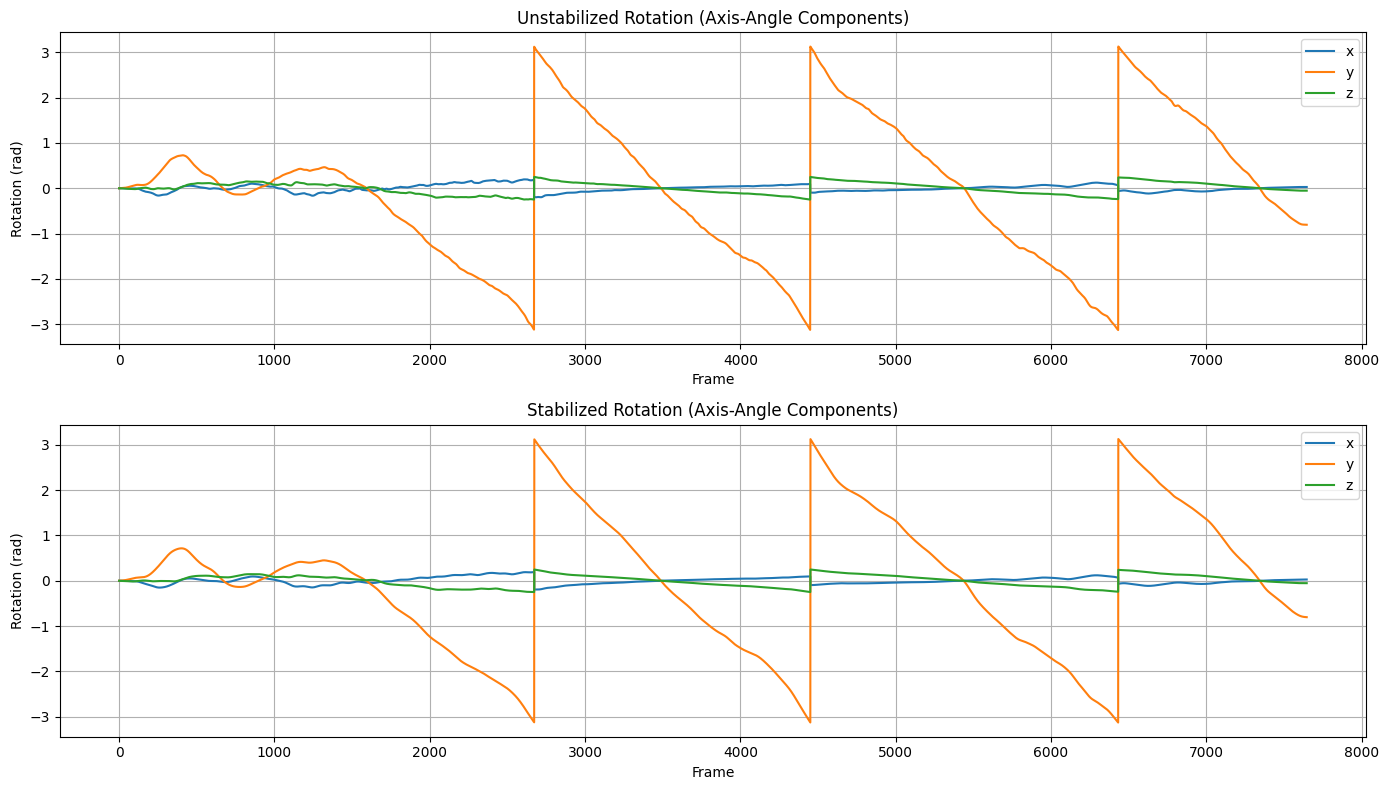

In [18]:
unstabilized_rotation = [R.from_matrix(romat).as_rotvec() for romat in rotations_cam_all]
stabilized_rotations = [R.from_matrix(romat).as_rotvec() for romat in rotations_prime_cam]

plt.figure(figsize=(14, 8))

# Unstabilized rotation components
unstabilized_rotation = np.array(unstabilized_rotation)
plt.subplot(2, 1, 1)
plt.plot(unstabilized_rotation[:, 0], label='x')
plt.plot(unstabilized_rotation[:, 1], label='y')
plt.plot(unstabilized_rotation[:, 2], label='z')
plt.title('Unstabilized Rotation (Axis-Angle Components)')
plt.xlabel('Frame')
plt.ylabel('Rotation (rad)')
plt.legend()
plt.grid(True)

# Stabilized rotation components
stabilized_rotations = np.array(stabilized_rotations)
plt.subplot(2, 1, 2)
plt.plot(stabilized_rotations[:, 0], label='x')
plt.plot(stabilized_rotations[:, 1], label='y')
plt.plot(stabilized_rotations[:, 2], label='z')
plt.title('Stabilized Rotation (Axis-Angle Components)')
plt.xlabel('Frame')
plt.ylabel('Rotation (rad)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

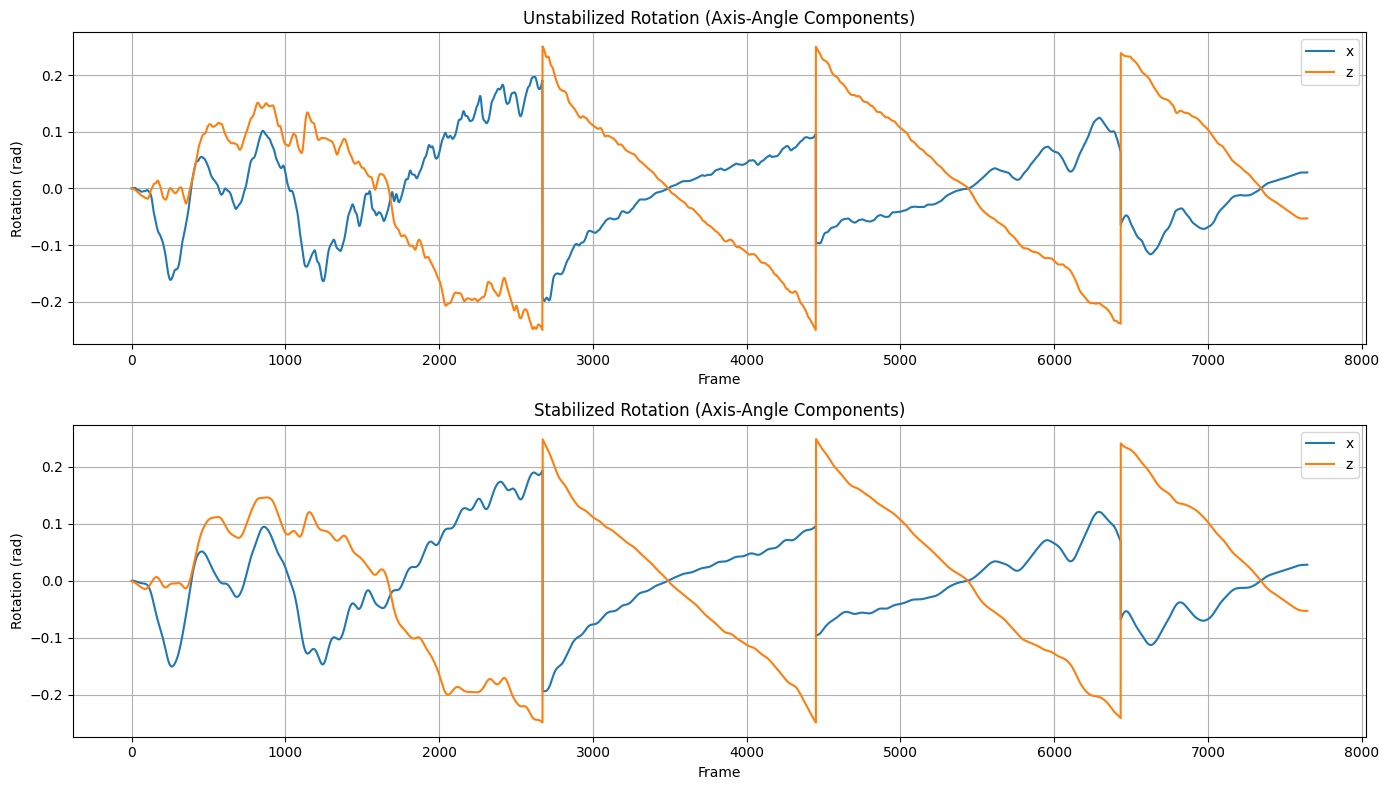

In [19]:
plt.figure(figsize=(14, 8))

# Unstabilized rotation components
unstabilized_rotation = np.array(unstabilized_rotation)
plt.subplot(2, 1, 1)
plt.plot(unstabilized_rotation[:, 0], label='x')
plt.plot(unstabilized_rotation[:, 2], label='z')
plt.title('Unstabilized Rotation (Axis-Angle Components)')
plt.xlabel('Frame')
plt.ylabel('Rotation (rad)')
plt.legend()
plt.grid(True)

# Stabilized rotation components
stabilized_rotations = np.array(stabilized_rotations)
plt.subplot(2, 1, 2)
plt.plot(stabilized_rotations[:, 0], label='x')
plt.plot(stabilized_rotations[:, 2], label='z')
plt.title('Stabilized Rotation (Axis-Angle Components)')
plt.xlabel('Frame')
plt.ylabel('Rotation (rad)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Meshgrid where angular velocity was maximum

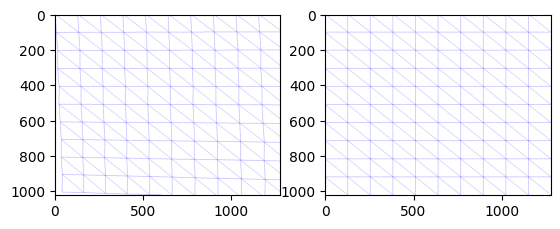

array([[28, 29, 28, ..., 56, 56, 54],
       [28, 29, 29, ..., 58, 58, 51],
       [28, 29, 29, ..., 58, 58, 46],
       ...,
       [35, 35, 35, ...,  0,  0,  0],
       [35, 35, 35, ...,  0,  0,  0],
       [34, 34, 34, ...,  0,  0,  0]], shape=(1024, 1280), dtype=uint8)

In [20]:
max_angular_velocity_ind = np.linalg.norm(gyro_data[:, 1:], axis=1).argmax()
max_angular_velocity_timestamp = gyro_data[max_angular_velocity_ind, 0] * 1e-9

frame_i = np.searchsorted(frame_timestamps_sec, max_angular_velocity_timestamp)

compensate_rs(
        frame, 
        rotations_cam_all,
        rotations_cam_all,
        K_new, 
        FPS, 
        ts,
        gyro_timestamps_sec,
        vert_splits,
        i=frame_i,
        frame_timestamp_sec=frame_timestamps_sec[frame_i],
        debug=True
)